# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [5]:
train_npz = np.load('data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('data/test_input.npz')
test_data  = test_npz['data']

In [6]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [7]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [8]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

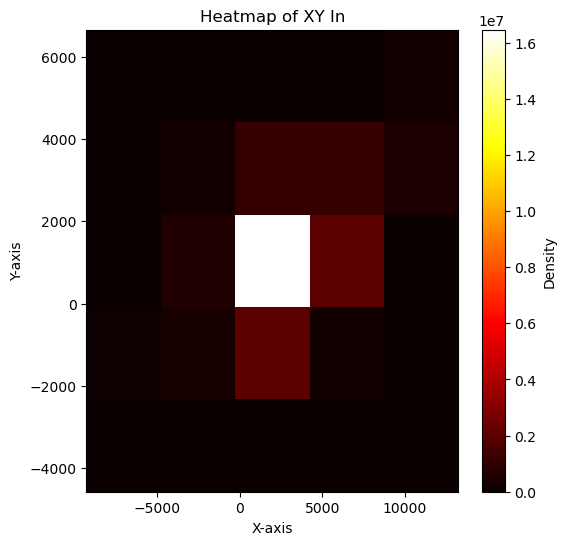

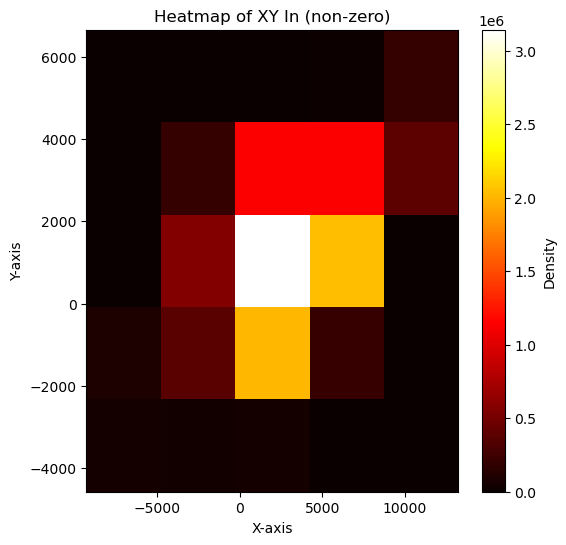

In [9]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

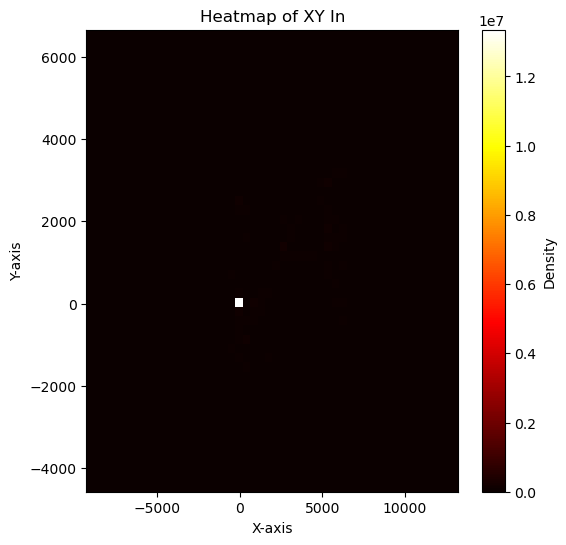

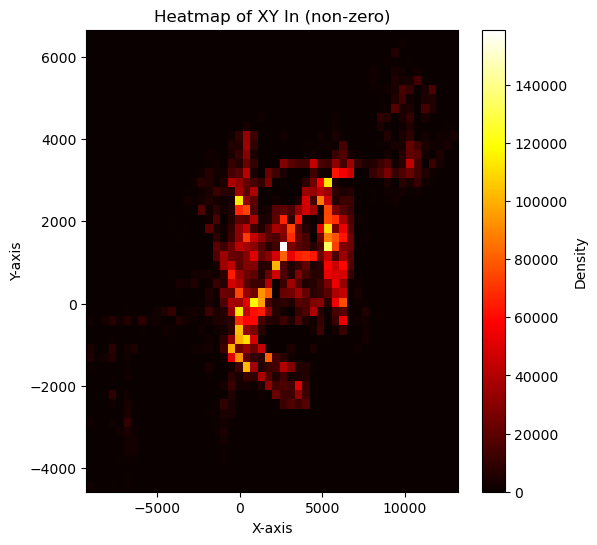

In [10]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Graph LSTM Implementation!

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super().__init__()
        self.agent_embed = nn.Linear(input_dim, hidden_dim)

        # Ego-focused attention layer across agents
        self.interaction = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_dim)
        )

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        ego_seq = x[:, 0, :, :]
        all_agents = x.permute(0, 2, 1, 3).reshape(-1, 50, 6)

        h = F.relu(self.agent_embed(all_agents))
        h_ego = h[:, 0:1, :]

        h_attn, _ = self.interaction(h_ego, h, h)
        h_attn = h_attn.squeeze(1).reshape(-1, 50, h_attn.size(-1))

        lstm_out, _ = self.lstm(h_attn)
        out = self.mlp(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)


In [47]:
model = GraphLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)
criterion = nn.MSELoss()

best_val = float('inf')
no_improvement = 0
patience = 10

for epoch in range(100):
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view(-1, 60, 2)
        loss = criterion(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            target = batch.y.view(-1, 60, 2)
            val_loss += criterion(pred, target).item()

    avg_train = train_loss / len(train_dataloader)
    avg_val = val_loss / len(val_dataloader)
    print(f"Epoch {epoch:03d} | Train MSE: {avg_train:.2f} | Val MSE: {avg_val:.2f}")

    if avg_val < best_val - 1e-3:
        best_val = avg_val
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping set here for no improvement.")
            break

    scheduler.step()


Epoch 000 | Train MSE: 2.74 | Val MSE: 1.06
Epoch 001 | Train MSE: 0.91 | Val MSE: 0.76
Epoch 002 | Train MSE: 0.74 | Val MSE: 0.95
Epoch 003 | Train MSE: 0.73 | Val MSE: 0.74
Epoch 004 | Train MSE: 0.71 | Val MSE: 0.68
Epoch 005 | Train MSE: 0.67 | Val MSE: 0.60
Epoch 006 | Train MSE: 0.62 | Val MSE: 0.62
Epoch 007 | Train MSE: 0.56 | Val MSE: 0.67
Epoch 008 | Train MSE: 0.53 | Val MSE: 0.66
Epoch 009 | Train MSE: 0.53 | Val MSE: 0.52
Epoch 010 | Train MSE: 0.49 | Val MSE: 0.57
Epoch 011 | Train MSE: 0.52 | Val MSE: 0.56
Epoch 012 | Train MSE: 0.47 | Val MSE: 0.50
Epoch 013 | Train MSE: 0.49 | Val MSE: 0.42
Epoch 014 | Train MSE: 0.38 | Val MSE: 0.45
Epoch 015 | Train MSE: 0.33 | Val MSE: 0.36
Epoch 016 | Train MSE: 0.31 | Val MSE: 0.35
Epoch 017 | Train MSE: 0.30 | Val MSE: 0.37
Epoch 018 | Train MSE: 0.30 | Val MSE: 0.34
Epoch 019 | Train MSE: 0.29 | Val MSE: 0.34
Epoch 020 | Train MSE: 0.28 | Val MSE: 0.32
Epoch 021 | Train MSE: 0.29 | Val MSE: 0.33
Epoch 022 | Train MSE: 0.27 | Va

In [48]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = GraphLSTM().to(device)


model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission-graph-lstm-2.csv', index=True)
print("done")

done
